In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from utils import wgs_cleaner, select_snps, gene_rep, filter_and_imput, clean_pat_wgs_id_ADNI, filter_and_impute_img
import os
from torch.nn.functional import log_softmax

In [3]:
dict_path = '../results/ADNI_full_abl_new_auxlossandarch_no_tune_lre-4_drop03_k256_units_256_noTFend_newclinfeat_clinF_nomaxpool_iter_0_results_dictionary.pkl'
quant_res_path = '../results/ADNI_full_abl_new_auxlossandarch_no_tune_lre-4_drop03_k256_units_256_noTFend_newclinfeat_clinF_nomaxpool_iter_0_results_summary.csv'
clin_feat_path =  '../data/ADNI/adni_clin_feat_names.txt'
img_feat_path =  '../data/ADNI/adni_img_roi_names_short.txt'
gen_feat_path =  '../data/ADNI/adni_gen_feat_names.txt'
clin_dat_path = '../data/ADNI/ADNIMERGE.csv'
img_dat_path = '../data/ADNI/imaging/TADPOLE_D1_D2.csv'
path_img_feat = '../../../../bulk/machad/ADNI/adni_img_feat_names_crossectional.txt'
path_feat_dict = '../../../../bulk/machad/ADNI/TADPOLE_D1_D2_Dict.csv'
path_roi_nm = '../../../../bulk/machad/ADNI/adni_img_roi_names.txt'
path_img_feat_short = '../data/ADNI/adni_img_roi_names_short.txt'
outcome_vars = ['MMSE','CDRSB', 'DX_bl']
demo_vars = ['PTID','AGE','PTGENDER','PTETHCAT','PTRACCAT']
clin_vars = ['RAVLT_immediate' ,'RAVLT_learning' ,'RAVLT_forgetting' ,'RAVLT_perc_forgetting' ,'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR']
impute,vis_colnm = 'True', 'VISCODE'
visit = 'bl'

### Load all pat data and compute descriptive stats

In [4]:
clin_dat = pd.read_csv(clin_dat_path)
img_data = pd.read_csv(img_dat_path)

/tmp/ipykernel_2754488/1966219425.py:1: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  clin_dat = pd.read_csv(clin_dat_path)
/tmp/ipykernel_2754488/1966219425.py:2: DtypeWarning: Columns (22,23,24,53,54,82,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  img_data = pd.read_csv(img_dat_path)


In [5]:
for var in outcome_vars:
    clin_dat = clin_dat[clin_dat[var].notna()]
clin_dat.PTID = clin_dat.PTID.apply(lambda x: clean_pat_wgs_id_ADNI(x))
clin_dat_bl_demo, clin_dat_bl_x, clin_dat_y  = filter_and_imput(clin_dat,'bl',demo_vars,clin_vars,outcome_vars,impute,vis_colnm)

In [6]:
roi_nm = np.loadtxt(path_roi_nm, dtype= 'str').tolist()
img_feat_short = np.loadtxt(path_img_feat_short, dtype= 'str').tolist()
img_feat_short_map = dict(zip(roi_nm,img_feat_short))

In [7]:
img_feat_nm = np.loadtxt(path_img_feat, dtype= 'str').tolist()
cols_interest = img_feat_nm
roi_df = pd.read_csv(path_feat_dict, dtype='str')
img_data['PTID']
img_data['PTID'] = img_data.PTID.apply(lambda x: clean_pat_wgs_id_ADNI(x))
img_data = img_data.set_index('PTID')

img_data = img_data.loc[img_data[vis_colnm] == visit,:]

# drop column for visit ID
img_data = img_data[img_data[vis_colnm].notna()]

# Filter cols / vars of interest
img_data = img_data.loc[:,cols_interest]

# Replace empty rows that have ' ' for nan
img_data = img_data.replace(r'^\s*$', np.nan, regex=True)

# Drop all rows that have all nans for patients
img_data = img_data.dropna(axis = 0, how = 'all')

# Filter for only Cross-Sectional analysis
roi_df = roi_df[roi_df['FLDNAME'].isin(cols_interest)]
roi_df = roi_df.loc[roi_df['CRFNAME'] == 'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)',:]

# Parse regions of interest
roi_df['ROI'] = roi_df['TEXT'].str.split('of',expand=True).iloc[:,1]
roi_df['Trait'] = roi_df['TEXT'].str.split('of',expand=True).iloc[:,0]
roi_df['Trait'] =  roi_df['Trait'].replace(r"^ +| +$", r"", regex=True)
roi_df = roi_df.set_index('FLDNAME')
roi_shared = roi_df.loc[roi_df['Trait'] == 'Cortical Thickness Average','ROI']
idx = img_data.index.values

In [8]:
img_data.columns = img_data.columns.map(roi_df.ROI.replace(r"^ +| +$", r"", regex=True).to_dict()).map(img_feat_short_map)
img_data = img_data.loc[:, img_data.columns.notna()]


In [9]:
clin_dat_bl_x.describe()

,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,36.522353,4.424471,4.218353,55.292831,7.753875,37.034398,115.413179
std,12.821157,2.784546,2.712804,36.499139,5.472213,8.121238,72.088317
min,0.000000,-8.000000,-28.000000,-400.000000,0.000000,0.000000,0.000000
25%,27.000000,2.000000,3.000000,26.250025,3.000000,37.034398,66.000000
50%,36.000000,4.000000,4.000000,55.292831,8.000000,37.034398,91.000000
75%,46.000000,6.000000,6.000000,100.000000,12.000000,37.034398,132.000000
max,71.000000,12.000000,15.000000,100.000000,23.000000,80.000000,300.000000


In [10]:
# with open('../results/ADNI_early_fusion_iter_0_results_dictionary.pkl', 'rb') as handle:
# with open('../results/ADNI_interCLS_fusion_weightCE_iter_0_results_dictionary.pkl', 'rb') as handle:
with open('../results/ADNI_full_abl_new_auxlossandarch_no_tune_lre-4_drop03_k256_units_256_noTFend_newclinfeat_clinF_nomaxpool_iter_0_results_dictionary.pkl', 'rb') as handle:
    data = handle.read()
d = pickle.loads(data)

In [16]:
d[0][0]['data']

{'lr': 0.0001,
 'batch_size': 64,
 'units': 256,
 'd_model': 256,
 'nhead': 4,
 'dim_feedforward': 256,
 'dropout': 0.0,
 'layer_norm_eps': 1e-06,
 'activation': 'relu',
 'checkpoint_path': '../checkpoints/ADNI_full_abl_new_auxlossandarch_no_tune_lre-4_drop03_k256_units_256_noTFend_newclinfeat_clinF_nomaxpool'}

In [12]:
# load quantitavie results summary table
quant_res = pd.read_csv(quant_res_path)
quant_res.auc_test.idxmax()

# load feature names
clin_feat = np.loadtxt(clin_feat_path, dtype='str').tolist()
img_feat = np.loadtxt(img_feat_path, dtype='str').tolist()
# gen_feat = np.loadtxt(gen_feat_path, dtype='str', delimiter="$").tolist() # Many gene names are not parsed properly so needed to add fake delimiter to allow for loading
gen_feat = np.loadtxt(gen_feat_path, dtype='str').tolist()

# find top performing model
best_model_idx = quant_res.auc_test.idxmax()
print(best_model_idx)
best_model = d[best_model_idx//5][best_model_idx-((best_model_idx//5)*5)]
# best_model_attributions = best_model['data']['attributions_l_test']

44


In [28]:
all_feat_names = np.concatenate(((np.asarray(clin_feat)), np.apply_along_axis(lambda d: d[0] + '_' + d[1], 1, np.asarray(list(zip(np.repeat(img_feat,4),['CTA','CTSD','SA','VOL']*len(img_feat))))), np.asarray(gen_feat)), axis=0)

In [29]:
rand_pat = 7
k=10

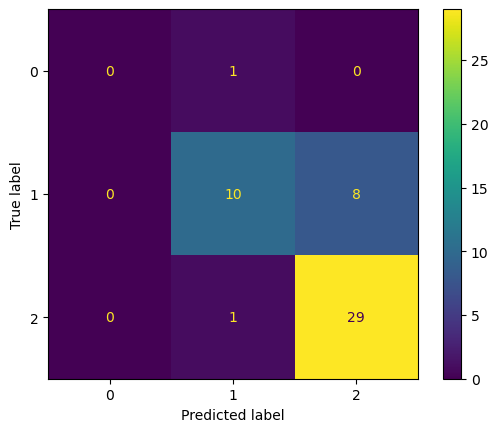

In [30]:
from torch.nn.functional import log_softmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test = best_model['data']['Pheno_og_test']
res = torch.Tensor(best_model['data']['sev_scores_test'])
preds = torch.exp(log_softmax(res,dim=1)).max(dim=1)[1]
cm = confusion_matrix(y_test, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot()

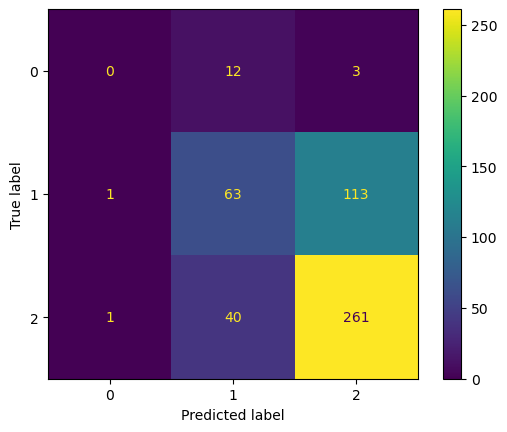

In [31]:
y_test_all = []
y_pred_all = []

for i in range(10):
    y_test_all.extend(d[i][0]['data']['Pheno_og_test'])
    y_pred_all.extend(torch.exp(log_softmax(torch.Tensor(d[i][0]['data']['sev_scores_test']),dim=1)).max(dim=1)[1])
cm = confusion_matrix(y_test_all, y_pred_all, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot()

In [32]:
np.unique(y_test_all, return_counts=True)

(array([0, 1, 2]), array([ 15, 177, 302]))

### Precision recall curves

In [33]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [34]:
y_test_all = []
y_pred_all = []
y_pred_all_max = []

for i in range(10):
    y_test_all.extend(d[i][0]['data']['Pheno_og_test'])
    y_pred_all.extend(torch.exp(log_softmax(torch.Tensor(d[i][0]['data']['sev_scores_test']),dim=1)))
    y_pred_all_max.extend(torch.argmax(torch.exp(log_softmax(torch.Tensor(d[i][0]['data']['sev_scores_test']),dim=1)),dim=1))

In [35]:
def plot_precision_recall_curve(y, y_proba, caller):
    # keep the algorithm's name to be written down into the graph
    algor_name = 'TriCOAT'
    
    # put y into multiple columns for OneVsRestClassifier
    onehotencoder = OneHotEncoder()
    y_hat = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()
    n_classes = y_hat.shape[1]

    # Compute ROC curve and ROC area for each class
    fig = plt.figure()
    plt.style.use('default')
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_hat[:, i], y_proba[:,i])
        plt.plot(recall[i], precision[i], lw=2, label='PR Curve of class {}'.format(i))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="lower right", prop={'size': 10})
    plt.title('Precision-Recall on ' + algor_name)
    # plt.suptitle(algor_name, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig('line_plot.pdf')  
    plt.show()

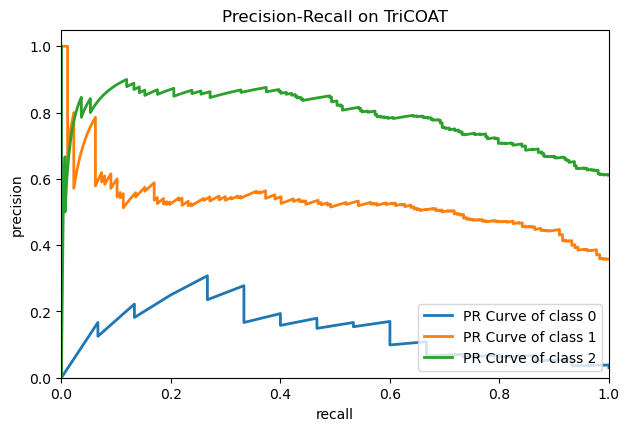

In [36]:
caller = 'ADNI dataset'
plot_precision_recall_curve(np.asarray(y_test_all), torch.stack(y_pred_all).numpy(), caller)

## Additional metrics

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

In [38]:
target_names = ['Fast', 'Slow', 'Intermediate']
print(classification_report(y_test_all, y_pred_all_max, target_names=target_names))


              precision    recall  f1-score   support

        Fast       0.00      0.00      0.00        15
        Slow       0.55      0.36      0.43       177
Intermediate       0.69      0.86      0.77       302

    accuracy                           0.66       494
   macro avg       0.41      0.41      0.40       494
weighted avg       0.62      0.66      0.62       494



In [39]:
balanced_accuracy_score(y_test_all, y_pred_all_max)


0.40672353799528566

In [40]:
recall_score(y_test_all, y_pred_all_max,  average='macro')


0.40672353799528566

In [41]:
precision_score(y_test_all, y_pred_all_max,  average='macro')


0.41337792642140464